# Appendix 4: Correlation Analysis

## Libraries

In [2]:
import pylab as plt
%matplotlib inline
import numpy as np
import sys
import glob
import gdal
import matplotlib.cm as cm
import os
import datetime
from scipy import interpolate
import pandas
from scipy.interpolate import spline
from pandas.tools.plotting import autocorrelation_plot
from pandas.tools.plotting import lag_plot
from astropy.convolution import convolve, Box1DKernel
from scipy import stats

 ## Loading subsidence velocity and production rate data

In [4]:
# production and subsidence of Yibal
y_prod = np.loadtxt("Yibal_Production.txt",usecols=(0,1,2)\
                    ,unpack=True,dtype=str)
y_sub = np.loadtxt("Yibal_sub_diff2.txt",usecols=(0,1,2,3),\
                    unpack=True,dtype=float)

# production and subsidence of QA (north)
qa_n_prod = np.loadtxt("sub_north.txt",usecols=(0,1)\
                       ,unpack=True,dtype=str)
qa_n_sub = np.loadtxt("QA_sub_north_diff.txt",usecols=(0,1,2,3)\
                      ,unpack=True,dtype=float)
# production and subsidence of QA (south)
qa_s_prod = np.loadtxt("sub_south.txt",usecols=(0,1)\
                       ,unpack=True,dtype=str)
qa_s_sub = np.loadtxt("QA_sub_south_diff.txt",usecols=(0,1,2,3)\
                      ,unpack=True,dtype=float)

## Calculating production rates for same epochs as subsidence velocities

In [5]:
# Qarn Alam production rate
fmt = '%d/%m/%y'
prod_mean_s=[]
prod_mean_n=[]
date_prod_24=[]
jd_qaprod_24=[]
qa_24_date=[]
qa_24_jd=[]
dd=[]
# for loop to get production rates for every epoch of sibsidenve velocity
for i in xrange(0,int(len(qa_s_prod[0])/24)+1):
    if i ==0:
        dt = datetime.datetime.strptime(qa_s_prod[0][i], fmt)
        tt = dt.timetuple()
        jd =tt.tm_year+(tt.tm_yday/365.)
        jd_qaprod_24.append(jd)
        qa_24_jd.append(jd)
        qa_24_date.append(dt)
        prod_mean_s.append(int(qa_s_prod[1][i])/(24*24))
        prod_mean_n.append(int(qa_n_prod[1][i])/(24*24))
    else:
        dt = datetime.datetime.strptime(qa_s_prod[0][i*24], fmt)
        tt = dt.timetuple()
        jd =tt.tm_year+(tt.tm_yday/365.)
# calculating mean value for production every 24 days
        prod_s=[]
        prod_n=[]
        for s in xrange(0,24):
            prod_s.append(float(qa_s_prod[1][24*i-s]))
            prod_n.append(float(qa_n_prod[1][24*i-s]))
        prod_mean_s.append(np.mean(prod_s)/(24*24))
        prod_mean_n.append(np.mean(prod_n)/(24*24))
        jd_qaprod_24.append(jd)
# dates of missing sar data
        if float(('%.3f'%jd)) != 2014.690 and float(('%.3f'%jd))\
!= 2015.348 and float(('%.3f'%jd)) != 2015.808 and float(('%.3f'%jd)) != 2015.874:
            qa_24_jd.append(jd)
            qa_24_date.append(dt)
    
prod_mean_s = np.array(prod_mean_s)
prod_mean_n = np.array(prod_mean_n)


# Yibal producion rates for epochs that correspond to sub velocity 
fmt = '%d/%m/%Y'
jd_y=[]
jd_y_24=[]
date_y_24=[]
# getting julian dates for monthly production data
for i in xrange(1,len(y_prod[0])):
    dt = datetime.datetime.strptime(y_prod[0][i], fmt)
    tt = dt.timetuple()
    jd =tt.tm_year+(tt.tm_yday/365.)
    jd_y.append(jd)
# getting the dates and julian dates for subsidence data    
for i in xrange(0,133):
    dt = datetime.datetime.strptime('15/07/2008', fmt) + datetime.timedelta(24*i)
    tt = dt.timetuple()
    jd =tt.tm_year+(tt.tm_yday/365.)
    if float(('%.3f'%jd)) != 2012.022 and float(('%.3f'%jd)) != 2012.219 and float(('%.3f'%jd)) != 2016.227:
        jd_y_24.append(jd)
        date_y_24.append(dt)
        

#linear interpolation to get production for sub velocity epochs
f = interpolate.interp1d(np.array(jd_y),y_prod[2][1:],kind='linear')
prod_24d = f(jd_y_24[1:])

## The data for the 3 subsidence areas

In [7]:
# QA dates and data
len(qa_24_jd)
#south
f = interpolate.interp1d(np.array(jd_qaprod_24),prod_mean_s,kind='linear')
qa_prod_s_24d = f(qa_24_jd)
qa_24_jd #time
qa_prod_s_24d #production
qa_south_sub = qa_s_sub[3][:-3] #subsidence
#north
f = interpolate.interp1d(np.array(jd_qaprod_24),prod_mean_n,kind='linear')
qa_prod_n_24d = f(qa_24_jd)
qa_24_jd #time
qa_prod_n_24d #production
qa_north_sub = qa_n_sub[3][:-3] # subsidence


# YIBAL dates and data
jd_y_24=jd_y_24[1:] #time
prod_24d #prod
y_sub_final = y_sub[3][1:-1] #subsidence

# 1. Yibal correlation

### 1.1 Yibal data plot

(2008.5, 2017.5)

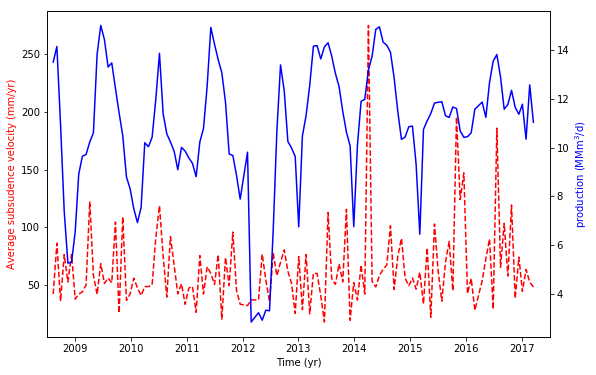

In [8]:

fig, ax1 = plt.subplots(1,1,figsize=(9,6))

ax1.set_xlabel('Time (yr)')
ax1.set_ylabel('Average subsudence velocity (mm/yr)', color='r')
ax2 = ax1.twinx()
ax1.plot(jd_y_24,y_sub_final,'r--',label='Average subsudence velocity')
ax2.plot(jd_y_24,prod_24d,'b',label='Production rate')

#plt.ylabel('Production (MMm$^{3}$/d)')
ax2.set_ylabel('production (MMm$^{3}$/d)', color='b')
plt.xlim(2008.5,2017.5)

### 1.2 Smoothing subsidence velocity using boxcar

(2008.5, 2017.5)

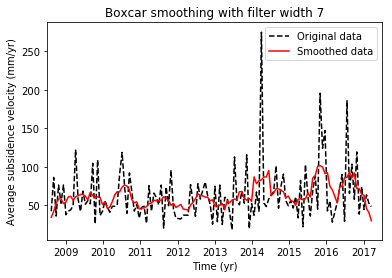

In [9]:
smoothed_sub = convolve(y_sub_final, Box1DKernel(7))
plt.plot(jd_y_24,y_sub_final,'k--',label='Original data')
plt.plot(jd_y_24,smoothed_sub,'r',label='Smoothed data')
plt.title('Boxcar smoothing with filter width 7')
plt.xlabel('Time (yr)')
plt.ylabel('Average subsidence velocity (mm/yr)')
plt.legend(loc='best')
plt.xlim(2008.5,2017.5)


### 1.3 plotting the smoothed subsidence and measured production

(2008.5, 2017.5)

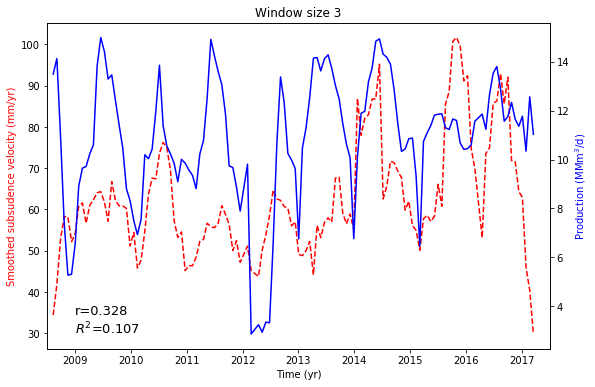

In [10]:
fig, ax1 = plt.subplots(1,1,figsize=(9,6))
prod_ts= pandas.Series(prod_24d)
sub_ts = pandas.Series(smoothed_sub)
correlation =  sub_ts.corr(prod_ts,method='pearson')
ax1.set_title('Window size 3')
ax1.text(2009, 30, 'r=%.3f\n$R^{2}$=%.3f'%(correlation,correlation**2), fontsize=13,clip_on=True)
#ax1.text(0, 0, 'r=%.3f\n$R^{2}$=%.3f'%(correlation,correlation**2),size=8)
ax1.set_xlabel('Time (yr)')
ax1.set_ylabel('Smoothed subsudence velocity (mm/yr)', color='r')
ax2 = ax1.twinx()
ax1.plot(jd_y_24,smoothed_sub,'r--',label='Average subsudence velocity')
ax2.plot(jd_y_24,prod_24d,'b',label='Production rate')

#plt.ylabel('Production (MMm$^{3}$/d)')
ax2.set_ylabel('Production (MMm$^{3}$/d)', color='b')
plt.xlim(2008.5,2017.5)

### 1.4 Correlation test for different window sizes

In [13]:
jd_y_24 #time
prod_24d2=prod_24d*1000 #prod
y_sub_final = y_sub[3][1:-1] #subsidence
w = 100
for i in xrange(0,len(prod_24d)-w):
    prod_ts= pandas.Series(prod_24d2[i:i+w])
    for ii in xrange(0,len(y_sub_final)-w):
        if jd_y_24[i]<=jd_y_24[ii]: 
            sub_ts = pandas.Series(smoothed_sub[ii:ii+w])
            correlation =  sub_ts.corr(prod_ts,method='pearson')
            if correlation > 0.4:
                print i, ii,i-ii, correlation,jd_y_24[i],'to',jd_y_24[i+w],jd_y_24[ii],'to',jd_y_24[ii+w]

0 15 -15 0.40710915263 2008.60547945 to 2015.30684932 2009.5890411 to 2016.35890411
0 16 -16 0.423430744342 2008.60547945 to 2015.30684932 2009.65479452 to 2016.42465753
1 1 0 0.431423576558 2008.67123288 to 2015.37260274 2008.67123288 to 2015.37260274
1 16 -15 0.413373700929 2008.67123288 to 2015.37260274 2009.65479452 to 2016.42465753
1 17 -16 0.422392081577 2008.67123288 to 2015.37260274 2009.72054795 to 2016.49041096
2 2 0 0.462437761411 2008.7369863 to 2015.43835616 2008.7369863 to 2015.43835616
2 17 -15 0.413651657431 2008.7369863 to 2015.43835616 2009.72054795 to 2016.49041096
2 18 -16 0.424721982816 2008.7369863 to 2015.43835616 2009.78630137 to 2016.55616438
3 3 0 0.463400519198 2008.80273973 to 2015.50410959 2008.80273973 to 2015.50410959
3 18 -15 0.414772545117 2008.80273973 to 2015.50410959 2009.78630137 to 2016.55616438
3 19 -16 0.425866988013 2008.80273973 to 2015.50410959 2009.85205479 to 2016.62191781
4 4 0 0.465999458997 2008.86849315 to 2015.56986301 2008.86849315 to 

### 1.5 Model Yibal (and All other subsidence areas)

(2008.5, 2017.5)

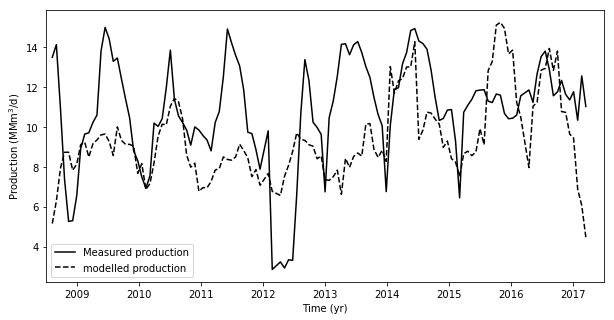

In [14]:
p =[0.15]
jd_y_24 #time
prod_24d #prod
y_sub_final = y_sub[3][1:-1] #subsidence

p=np.array(p)
def yibal_model(p,data):
    #meltDays = np.where(data['temp'] > tempThresh)[0]
    accum = data*0.
    sub_prod = p[0] * data     
    for i in xrange(0,len(data)):
        accum[i]=sub_prod[i]
    return accum


# test it
accum = yibal_model(p,smoothed_sub)
plt.figure(figsize=(10,5))
plt.plot(jd_y_24,prod_24d,'k',label='Measured production')
plt.plot(jd_y_24,accum,'k--',label='modelled production')
plt.ylabel('Production (MMm$^{3}$/d)')
plt.xlabel('Time (yr)')
plt.legend(loc='best')
plt.xlim(2008.5,2017.5)

### Cost Function

In [15]:

def J_obs(p, x, y, sd,\
                      model=yibal_model):
    '''
    
    return 'cost' J
    
    p    : set (vector) of parameters
    x    : sample locations
    y    : function value at sample locations
    sd   : uncertainty standard deviation
           *or* if not same shape as y, then
           assumed to be C1 (inverse var/covar matrix)
        
    '''
    y_hat = model(p, x)

    if sd.shape == y.shape:
        diff = (y_hat - y)/sd
        J = 0.5 * (diff*diff).sum()
    else:
        diff = np.matrix(y_hat - y).T
        J = 0.5 * np.array(diff.T * C1 * diff).flatten()[0]
    
    return J

### Model Evaluation

In [17]:
def r_squared(y,y_hat):

    y_bar = sum(y)/len(y)
    y_hat_bar = sum(y_hat)/len(y_hat)
    a = y-y_bar
    b = y_hat - y_hat_bar
    c=0
    for i in xrange(0,len(y)):
        c=c+a[i]*b[i]
    d=np.sqrt(sum(a**2))
    e=np.sqrt(sum(b**2))
    r_sq=(c/(d*e))**2
    return r_sq
def deviation(y,y_hat):

    a = y_hat-y
    b=sum(a)
    c=sum(y)
    d= (b/c)*100.
    return d
def Efficiency(y,y_hat):
    
    y_bar = np.mean(y)
    a = y-y_hat
    b=sum(a**2)
    c=y-y_bar
    d= sum(c**2)
    NS = 1 - (b/d)
    return NS

### 1.6 LUT

(2, 2)
(10000, 2)

Estimated Parameters [  0.16363636  16.16161616]

J(min) squared =  203880.27366

J(min) =  451.531032887
R-squared 0.16
percent deviation of stream flow volume -2.97
Efficiency -0.06
Correlation 0.40
113 2008.60547945 2016.16164384


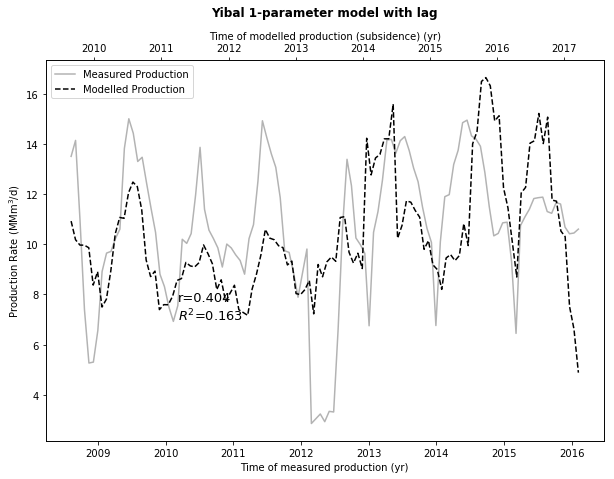

In [31]:
'''
model parameter estimation using look-up table method
to find the combination of parameters that achieve the lowest
cost.
This code is taken directly from ''Model Fitting''
by P Lewis https://github.com/profLewis/geogg122/blob/master/
Chapter5_Interpolation/Model_fitting.ipynb
'''
# initial parameters
p =[2.3,0]
sd=unc= np.ones(len(prod_24d))

# Yibal data
jd_y_24 #time
prod_24d #prod
y_sub_final = y_sub[3][1:-1] #subsidence
z=smoothed_sub

# parameter ranges
b = np.array([(0.1,0.2),(0,20)])

# window to specify the observations used in the LUT
start= 0
finish = 129

print b.shape
import itertools
n_samples =100 # 5 samples by dimension
pre_lut = np.zeros((2,n_samples)) # For each dimension, we store one
#vector with n_samples
for i in xrange(2):
    pre_lut[i,:] = np.linspace ( b[i,0], b[i,1], n_samples)
# Generates the LUT by doing a cartesian product of the 6 dimensions
LUT = [xx for xx in itertools.product ( pre_lut[0], pre_lut[1])]
LUT = np.array(LUT) # Convert to array
print LUT.shape

# Calculate the cost function for each lag parameter possible
cost_f = lambda pp: J_obs(pp,z[start+int(pp[1]):finish],prod_24d[start:finish-int(pp[1])],\
sd[start+int(pp[1]):finish],model=yibal_model)**2
cost = map(cost_f, LUT)
cost = np.array(cost)
iloc = cost.argmin()
pp = LUT[iloc,:]
prod_modelled = yibal_model(pp,z[start+int(pp[1]):finish])
print '\nEstimated Parameters',pp
print '\nJ(min) squared = ',cost[iloc]
print '\nJ(min) = ',J_obs(pp,z[start+int(pp[1]):finish],prod_24d[start:finish-int(pp[1])]\
                          ,sd[start:finish-int(pp[1])])

y_hat = yibal_model(LUT[iloc,:],z[start+int(pp[1]):finish])
# model evaluation statistics
r_sq = r_squared(prod_24d[start:finish-int(pp[1])],y_hat)
dv= deviation(prod_24d[start:finish-int(pp[1])],y_hat)
e = Efficiency(prod_24d[start:finish-int(pp[1])],y_hat)

prod_ts = pandas.Series(prod_24d[start:finish-int(pp[1])])       
mod_ts = pandas.Series(y_hat)
correlation =  mod_ts.corr(prod_ts,method='pearson')
# print model evaluation statistics
print 'R-squared', ('%.2f' %r_sq)
print 'percent deviation of stream flow volume', ('%.2f' %dv)
print 'Efficiency', ('%.2f' %e)
print 'Correlation', ('%.2f' %correlation)

# plotting the measured and modelled production
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)
ax1.set_title('Yibal 1-parameter model with lag',y=1.1,fontweight="bold")
ax1.plot(jd_y_24[start:finish-int(pp[1])],prod_24d[start:finish-int(pp[1])],color = '0.70',label='Measured Production')

ax1.set_ylabel('Production Rate (MMm$^{3}$/d)')
ax1.set_xlabel('Time of measured production (yr)')
ax2 = ax1.twiny()
ax2.plot(jd_y_24[start+int(pp[1]):finish]\
        ,y_hat,'k--',label='Modelled Production')
ax2.set_xlabel('Time of modelled production (subsidence) (yr)')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=2)
plt.text(2011.25, 7, 'r=%.3f\n$R^{2}$=%.3f'%(correlation,correlation**2), fontsize=13,clip_on=True)
print len(prod_24d[start:finish-int(pp[1])]),jd_y_24[start],jd_y_24[finish-int(pp[1])]

### LUT with smaller window (less observations)

(2, 2)
(10000, 2)

Estimated Parameters [  0.19494949  15.15151515]

J(min) squared =  592.871680435

J(min) =  24.3489564548
R-squared 0.67
percent deviation of stream flow volume 0.43
Efficiency 0.60
Correlation 0.82
31 2010.04931507 2012.15342466


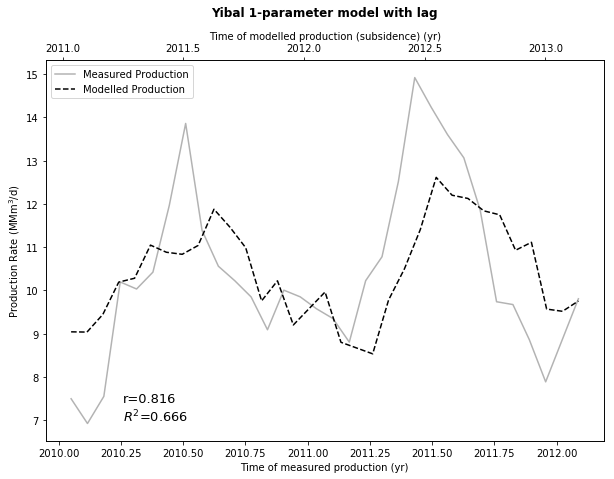

In [32]:
'''
model parameter estimation using look-up table method
to find the combination of parameters that achieve the lowest
cost.
This code is taken directly from ''Model Fitting''
by P Lewis https://github.com/profLewis/geogg122/blob/master/
Chapter5_Interpolation/Model_fitting.ipynb
'''
# initial parameters
p =[2.3,0]
sd=unc= np.ones(len(prod_24d))

# Yibal data
jd_y_24 #time
prod_24d #prod
y_sub_final = y_sub[3][1:-1] #subsidence
z=smoothed_sub

# parameter ranges
b = np.array([(0.1,0.2),(0,20)])

# window to specify the observations used in the LUT
start= 22
finish = 68

print b.shape
import itertools
n_samples =100 # 5 samples by dimension
pre_lut = np.zeros((2,n_samples)) # For each dimension, we store one
#vector with n_samples
for i in xrange(2):
    pre_lut[i,:] = np.linspace ( b[i,0], b[i,1], n_samples)
# Generates the LUT by doing a cartesian product of the 6 dimensions
LUT = [xx for xx in itertools.product ( pre_lut[0], pre_lut[1])]
LUT = np.array(LUT) # Convert to array
print LUT.shape

# Calculate the cost function for each lag parameter possible
cost_f = lambda pp: J_obs(pp,z[start+int(pp[1]):finish],prod_24d[start:finish-int(pp[1])],\
sd[start+int(pp[1]):finish],model=yibal_model)**2
cost = map(cost_f, LUT)
cost = np.array(cost)
iloc = cost.argmin()
pp = LUT[iloc,:]
prod_modelled = yibal_model(pp,z[start+int(pp[1]):finish])
print '\nEstimated Parameters',pp
print '\nJ(min) squared = ',cost[iloc]
print '\nJ(min) = ',J_obs(pp,z[start+int(pp[1]):finish],prod_24d[start:finish-int(pp[1])]\
                          ,sd[start:finish-int(pp[1])])

y_hat = yibal_model(LUT[iloc,:],z[start+int(pp[1]):finish])
# model evaluation statistics
r_sq = r_squared(prod_24d[start:finish-int(pp[1])],y_hat)
dv= deviation(prod_24d[start:finish-int(pp[1])],y_hat)
e = Efficiency(prod_24d[start:finish-int(pp[1])],y_hat)

prod_ts = pandas.Series(prod_24d[start:finish-int(pp[1])])       
mod_ts = pandas.Series(y_hat)
correlation =  mod_ts.corr(prod_ts,method='pearson')
# print model evaluation statistics
print 'R-squared', ('%.2f' %r_sq)
print 'percent deviation of stream flow volume', ('%.2f' %dv)
print 'Efficiency', ('%.2f' %e)
print 'Correlation', ('%.2f' %correlation)

# plotting the measured and modelled production
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)
ax1.set_title('Yibal 1-parameter model with lag',y=1.1,fontweight="bold")
ax1.plot(jd_y_24[start:finish-int(pp[1])],prod_24d[start:finish-int(pp[1])],color = '0.70',label='Measured Production')

ax1.set_ylabel('Production Rate (MMm$^{3}$/d)')
ax1.set_xlabel('Time of measured production (yr)')
ax2 = ax1.twiny()
ax2.plot(jd_y_24[start+int(pp[1]):finish]\
        ,y_hat,'k--',label='Modelled Production')
ax2.set_xlabel('Time of modelled production (subsidence) (yr)')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=2)
plt.text(2011.25, 7, 'r=%.3f\n$R^{2}$=%.3f'%(correlation,correlation**2), fontsize=13,clip_on=True)
print len(prod_24d[start:finish-int(pp[1])]),jd_y_24[start],jd_y_24[finish-int(pp[1])]

## 2. Correlation and lag Qarn Alam north

### data

In [43]:
qa_24_jd #time
qa_prod_n_24d #production
qa_north_sub = qa_n_sub[3][:-3] # subsidence

### 2.1 Subsidence velocities and production rates plot

(2014, 2017)

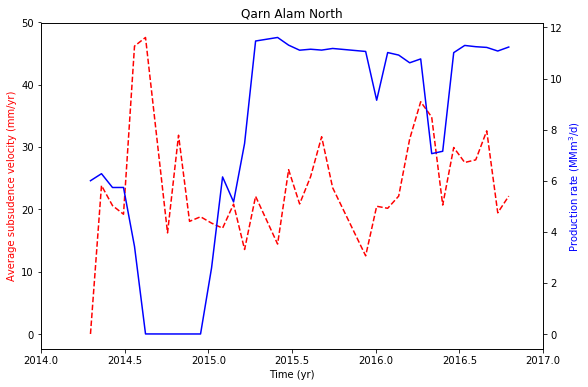

In [44]:
fig, ax1 = plt.subplots(1,1,figsize=(9,6))

ax1.set_title('Qarn Alam North')
ax1.set_xlabel('Time (yr)')
ax1.set_ylabel('Average subsudence velocity (mm/yr)', color='r')
ax2 = ax1.twinx()
ax1.plot(qa_24_jd,qa_north_sub,'r--',label='Average subsudence velocity')
ax2.plot(qa_24_jd,qa_prod_n_24d,'b',label='Production rate')

#plt.ylabel('Production (MMm$^{3}$/d)')
ax2.set_ylabel('Production rate (MMm$^{3}$/d)', color='b')
plt.xlim(2014,2017)

### 2.2 Smoothing subsidence velocities

2014.2547945205479

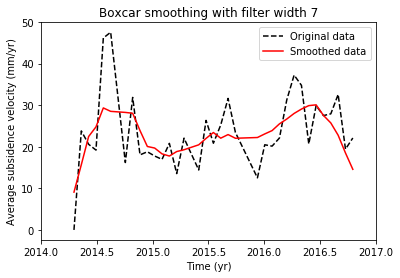

In [33]:
# Window size of 7
smoothed_qa_n = convolve(qa_north_sub, Box1DKernel(7))
plt.plot(qa_24_jd,qa_north_sub,'k--',label='Original data')
plt.plot(qa_24_jd,smoothed_qa_n,'r',label='Smoothed data')
plt.title('Boxcar smoothing with filter width 7')
plt.xlabel('Time (yr)')
plt.ylabel('Average subsidence velocity (mm/yr)')
plt.legend(loc='best')
plt.xlim(2014,2017)
jd_y_24[84]

### 2.3 Smoothed subsidence velocities and production rates

(2014, 2017)

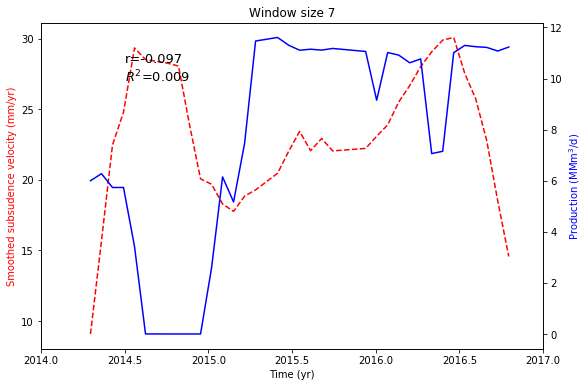

In [34]:
fig, ax1 = plt.subplots(1,1,figsize=(9,6))
prod_ts= pandas.Series(qa_prod_n_24d)
sub_ts = pandas.Series(smoothed_qa_n)
correlation =  sub_ts.corr(prod_ts,method='pearson')
ax1.set_title('Window size 7')
ax1.text(2014.5, 27, 'r=%.3f\n$R^{2}$=%.3f'%(correlation,correlation**2), fontsize=13,clip_on=True)
#ax1.text(0, 0, 'r=%.3f\n$R^{2}$=%.3f'%(correlation,correlation**2),size=8)
ax1.set_xlabel('Time (yr)')
ax1.set_ylabel('Smoothed subsudence velocity (mm/yr)', color='r')
ax2 = ax1.twinx()
ax1.plot(qa_24_jd,smoothed_qa_n,'r--',label='Average subsudence velocity')
ax2.plot(qa_24_jd,qa_prod_n_24d,'b',label='Production rate')

#plt.ylabel('Production (MMm$^{3}$/d)')
ax2.set_ylabel('Production (MMm$^{3}$/d)', color='b')
plt.xlim(2014,2017)

### 2.4 LUT table to find parameters

(2, 2)
(10000, 2)

Estimated Parameters [ 0.31313131  6.06060606]

J(min) squared =  32374.1191571

J(min) =  179.928094407
R-squared 0.37
percent deviation of stream flow volume 2.97
Efficiency 0.27
Correlation 0.60


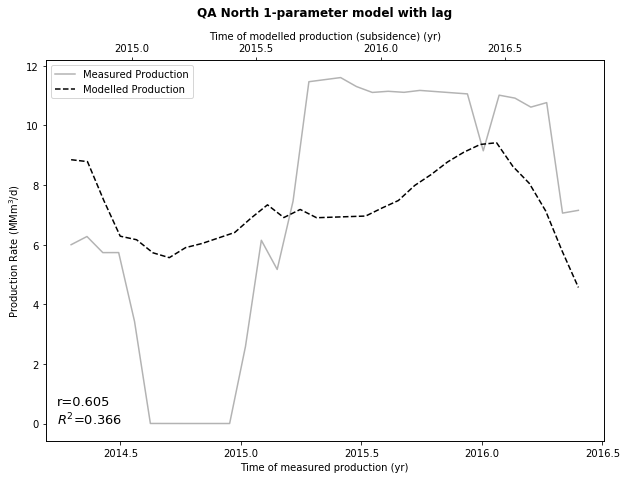

In [36]:
'''
model parameter estimation using look-up table method
to find the combination of parameters that achieve the lowest
cost.
This code is taken directly from ''Model Fitting''
by P Lewis https://github.com/profLewis/geogg122/blob/master/
Chapter5_Interpolation/Model_fitting.ipynb
'''

# standard deviation of 1
sd=unc= np.ones(len(qa_prod_n_24d))

# data of QA north
qa_24_jd #time
qa_prod_n_24d #production
qa_north_sub = qa_n_sub[3][:-3] # subsidence
z=smoothed_qa_n

# parameters ranges of scaling parameter and lag
b = np.array([(0.,1),(0,15)])
start= 0
finish = 35

print b.shape
import itertools
n_samples =100 # 5 samples by dimension
pre_lut = np.zeros((2,n_samples)) # For each dimension, we store one
#vector with n_samples
for i in xrange(2):
    pre_lut[i,:] = np.linspace ( b[i,0], b[i,1], n_samples)
# Generates the LUT by doing a cartesian product of the 6 dimensions
LUT = [xx for xx in itertools.product ( pre_lut[0], pre_lut[1])]
LUT = np.array(LUT) # Convert to array
print LUT.shape

# Calculate the cost function for each possible lag
cost_f = lambda pp: J_obs(pp,z[start+int(pp[1]):finish],qa_prod_n_24d[start:finish-int(pp[1])],\
sd[start+int(pp[1]):finish],model=yibal_model)**2
cost = map(cost_f, LUT)
cost = np.array(cost)
iloc = cost.argmin()
pp = LUT[iloc,:]
prod_modelled = yibal_model(pp,z[start+int(pp[1]):finish])
print '\nEstimated Parameters',pp
print '\nJ(min) squared = ',cost[iloc]
print '\nJ(min) = ',J_obs(pp,z[start+int(pp[1]):finish],qa_prod_n_24d[start:finish-int(pp[1])]\
                          ,sd[start:finish-int(pp[1])])

y_hat = yibal_model(LUT[iloc,:],z[start+int(pp[1]):finish])
# model evaluation statistics
r_sq = r_squared(qa_prod_n_24d[start:finish-int(pp[1])],y_hat)
dv= deviation(qa_prod_n_24d[start:finish-int(pp[1])],y_hat)
e = Efficiency(qa_prod_n_24d[start:finish-int(pp[1])],y_hat)

prod_ts = pandas.Series(qa_prod_n_24d[start:finish-int(pp[1])])       
mod_ts = pandas.Series(y_hat)
correlation =  mod_ts.corr(prod_ts,method='pearson')
# print model evaluation statistics
print 'R-squared', ('%.2f' %r_sq)
print 'percent deviation of stream flow volume', ('%.2f' %dv)
print 'Efficiency', ('%.2f' %e)
print 'Correlation', ('%.2f' %correlation)

fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)
ax1.set_title('QA North 1-parameter model with lag',y=1.1,fontweight="bold")

ax1.plot(qa_24_jd[start:finish-int(pp[1])],qa_prod_n_24d[start:finish-int(pp[1])],color = '0.70',label='Measured Production')

ax1.set_xlabel('Time of measured production (yr)')

ax2 = ax1.twiny()
ax1.set_ylabel('Production Rate (MMm$^{3}$/d)')
ax2.plot(qa_24_jd[start+int(pp[1]):finish]\
        ,y_hat,'k--',label='Modelled Production')
ax2.set_xlabel('Time of modelled production (subsidence) (yr)')
ax2.set_xticks(np.arange(2015,2017,0.5))
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=2)
#ax1.plot(y_sub[0],production_modelled,'k--',label='modelled')


plt.text(2014.7, 0, 'r=%.3f\n$R^{2}$=%.3f'%(correlation,correlation**2), fontsize=13,clip_on=True)




## 3. Qarn Alam South

### 3.1 Data of QA south

In [8]:
qa_24_jd #time
qa_prod_s_24d #production
qa_south_sub = qa_s_sub[3][:-3] #subsidence

### 3.2 plotting subsidence velocities and production rates of QA South

(2014, 2017)

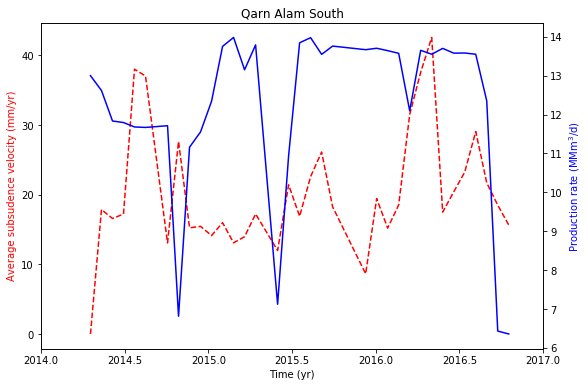

In [37]:
fig, ax1 = plt.subplots(1,1,figsize=(9,6))

ax1.set_title('Qarn Alam South')
ax1.set_xlabel('Time (yr)')
ax1.set_ylabel('Average subsudence velocity (mm/yr)', color='r')
ax2 = ax1.twinx()
ax1.plot(qa_24_jd,qa_south_sub,'r--',label='Average subsudence velocity')
ax2.plot(qa_24_jd,qa_prod_s_24d,'b',label='Production rate')

#plt.ylabel('Production (MMm$^{3}$/d)')
ax2.set_ylabel('Production rate (MMm$^{3}$/d)', color='b')
plt.xlim(2014,2017)

### 3.3 Smoothing the subsidence velocities of QA south

2014.2547945205479

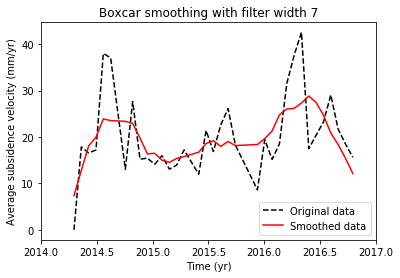

In [38]:
smoothed_qa_s = convolve(qa_south_sub, Box1DKernel(7))
plt.plot(qa_24_jd,qa_south_sub,'k--',label='Original data')
plt.plot(qa_24_jd,smoothed_qa_s,'r',label='Smoothed data')
plt.title('Boxcar smoothing with filter width 7')
plt.xlabel('Time (yr)')
plt.ylabel('Average subsidence velocity (mm/yr)')
plt.legend(loc='best')
plt.xlim(2014,2017)
jd_y_24[84]

### 3.4 LUT (with lag)

(2, 2)
(40000, 2)

Estimated Parameters [ 0.36180905  6.03015075]

J(min) squared =  26998.7396958

J(min) =  164.312932223
R-squared 0.17
percent deviation of stream flow volume -41.87
Efficiency -8.72
Correlation 0.41


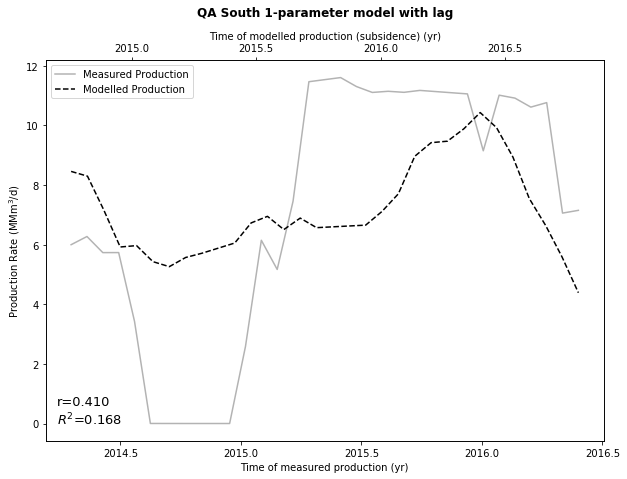

In [42]:
'''
model parameter estimation using look-up table method
to find the combination of parameters that achieve the lowest
cost.
This code is taken directly from ''Model Fitting''
by P Lewis https://github.com/profLewis/geogg122/blob/master/
Chapter5_Interpolation/Model_fitting.ipynb
'''
# standard deviation
sd=unc= np.ones(len(qa_prod_s_24d))

# data of QA south
qa_24_jd #time
qa_prod_n_24d #production
qa_north_sub = qa_n_sub[3][:-3] # subsidence
z=smoothed_qa_s

#ranges of parameters
b = np.array([(0.,2),(0,16)])

# start and finish (window of obs)
start= 0
finish = 35

print b.shape
import itertools
n_samples =200 # 5 samples by dimension
pre_lut = np.zeros((2,n_samples)) # For each dimension, we store one
#vector with n_samples
for i in xrange(2):
    pre_lut[i,:] = np.linspace ( b[i,0], b[i,1], n_samples)
# Generates the LUT by doing a cartesian product of the 6 dimensions
LUT = [xx for xx in itertools.product ( pre_lut[0], pre_lut[1])]
LUT = np.array(LUT) # Convert to array
print LUT.shape

# Calculate the cost function using different lags
cost_f = lambda pp: J_obs(pp,z[start+int(pp[1]):finish],qa_prod_n_24d[start:finish-int(pp[1])],\
sd[start+int(pp[1]):finish],model=yibal_model)**2
cost = map(cost_f, LUT)
cost = np.array(cost)
iloc = cost.argmin()
pp = LUT[iloc,:]
prod_modelled = yibal_model(pp,z[start+int(pp[1]):finish])

print '\nEstimated Parameters',pp
print '\nJ(min) squared = ',cost[iloc]
print '\nJ(min) = ',J_obs(pp,z[start+int(pp[1]):finish],qa_prod_n_24d[start:finish-int(pp[1])]\
                          ,sd[start:finish-int(pp[1])])

y_hat = yibal_model(LUT[iloc,:],z[start+int(pp[1]):finish])
# model evaluation statistics
r_sq = r_squared(qa_prod_s_24d[start:finish-int(pp[1])],y_hat)
dv= deviation(qa_prod_s_24d[start:finish-int(pp[1])],y_hat)
e = Efficiency(qa_prod_s_24d[start:finish-int(pp[1])],y_hat)

prod_ts = pandas.Series(qa_prod_s_24d[start:finish-int(pp[1])])       
mod_ts = pandas.Series(y_hat)
correlation =  mod_ts.corr(prod_ts,method='pearson')
# print model evaluation statistics
print 'R-squared', ('%.2f' %r_sq)
print 'percent deviation of stream flow volume', ('%.2f' %dv)
print 'Efficiency', ('%.2f' %e)
print 'Correlation', ('%.2f' %correlation)

fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)
ax1.set_title('QA South 1-parameter model with lag',y=1.1,fontweight="bold")

ax1.plot(qa_24_jd[start:finish-int(pp[1])],qa_prod_n_24d[start:finish-int(pp[1])],color = '0.70',label='Measured Production')

ax1.set_xlabel('Time of measured production (yr)')

ax2 = ax1.twiny()
ax1.set_ylabel('Production Rate (MMm$^{3}$/d)')
ax2.plot(qa_24_jd[start+int(pp[1]):finish]\
        ,y_hat,'k--',label='Modelled Production')
ax2.set_xlabel('Time of modelled production (subsidence) (yr)')
ax2.set_xticks(np.arange(2015,2017,0.5))
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=2)
#ax1.plot(y_sub[0],production_modelled,'k--',label='modelled')


plt.text(2014.7, 0, 'r=%.3f\n$R^{2}$=%.3f'%(correlation,correlation**2), fontsize=13,clip_on=True)



### 3.5 LUT QA south no lag

(2, 2)
(40000, 2)

Estimated Parameters [ 0.3718593  0.       ]

J(min) squared =  121748.473543

J(min) =  348.924739081
R-squared 0.04
percent deviation of stream flow volume -40.27
Efficiency -5.40
Correlation 0.21


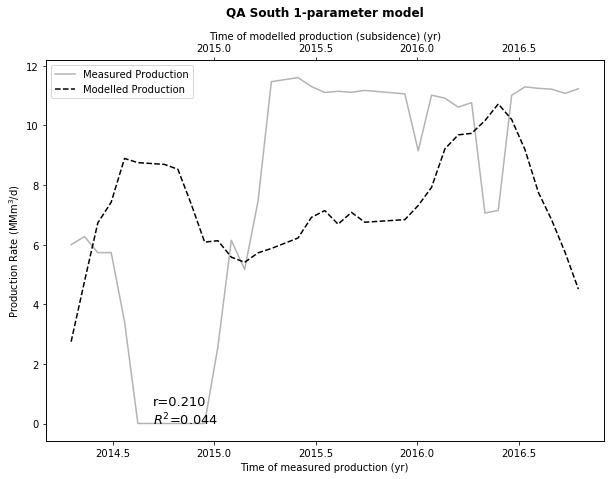

In [44]:
'''
model parameter estimation using look-up table method
to find the combination of parameters that achieve the lowest
cost.
This code is taken directly from ''Model Fitting''
by P Lewis https://github.com/profLewis/geogg122/blob/master/
Chapter5_Interpolation/Model_fitting.ipynb
'''
# standard deviation
sd=unc= np.ones(len(qa_prod_s_24d))

# data of QA south
qa_24_jd #time
qa_prod_n_24d #production
qa_north_sub = qa_n_sub[3][:-3] # subsidence
z=smoothed_qa_s

#ranges of parameters (0 for lag)
b = np.array([(0.,2),(0,0)])

# start and finish (window of obs)
start= 0
finish = 35

print b.shape
import itertools
n_samples =200 # 5 samples by dimension
pre_lut = np.zeros((2,n_samples)) # For each dimension, we store one
#vector with n_samples
for i in xrange(2):
    pre_lut[i,:] = np.linspace ( b[i,0], b[i,1], n_samples)
# Generates the LUT by doing a cartesian product of the 6 dimensions
LUT = [xx for xx in itertools.product ( pre_lut[0], pre_lut[1])]
LUT = np.array(LUT) # Convert to array
print LUT.shape

# Calculate the cost function using different lags
cost_f = lambda pp: J_obs(pp,z[start+int(pp[1]):finish],qa_prod_n_24d[start:finish-int(pp[1])],\
sd[start+int(pp[1]):finish],model=yibal_model)**2
cost = map(cost_f, LUT)
cost = np.array(cost)
iloc = cost.argmin()
pp = LUT[iloc,:]
prod_modelled = yibal_model(pp,z[start+int(pp[1]):finish])

print '\nEstimated Parameters',pp
print '\nJ(min) squared = ',cost[iloc]
print '\nJ(min) = ',J_obs(pp,z[start+int(pp[1]):finish],qa_prod_n_24d[start:finish-int(pp[1])]\
                          ,sd[start:finish-int(pp[1])])

y_hat = yibal_model(LUT[iloc,:],z[start+int(pp[1]):finish])
# model evaluation statistics
r_sq = r_squared(qa_prod_s_24d[start:finish-int(pp[1])],y_hat)
dv= deviation(qa_prod_s_24d[start:finish-int(pp[1])],y_hat)
e = Efficiency(qa_prod_s_24d[start:finish-int(pp[1])],y_hat)

prod_ts = pandas.Series(qa_prod_s_24d[start:finish-int(pp[1])])       
mod_ts = pandas.Series(y_hat)
correlation =  mod_ts.corr(prod_ts,method='pearson')
# print model evaluation statistics
print 'R-squared', ('%.2f' %r_sq)
print 'percent deviation of stream flow volume', ('%.2f' %dv)
print 'Efficiency', ('%.2f' %e)
print 'Correlation', ('%.2f' %correlation)

fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)
ax1.set_title('QA South 1-parameter model',y=1.1,fontweight="bold")

ax1.plot(qa_24_jd[start:finish-int(pp[1])],qa_prod_n_24d[start:finish-int(pp[1])],color = '0.70',label='Measured Production')

ax1.set_xlabel('Time of measured production (yr)')

ax2 = ax1.twiny()
ax1.set_ylabel('Production Rate (MMm$^{3}$/d)')
ax2.plot(qa_24_jd[start+int(pp[1]):finish]\
        ,y_hat,'k--',label='Modelled Production')
ax2.set_xlabel('Time of modelled production (subsidence) (yr)')
ax2.set_xticks(np.arange(2015,2017,0.5))
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=2)
#ax1.plot(y_sub[0],production_modelled,'k--',label='modelled')


plt.text(2014.7, 0, 'r=%.3f\n$R^{2}$=%.3f'%(correlation,correlation**2), fontsize=13,clip_on=True)

